In [ ]:
import pandas as pd 
import os
import numpy as np
from matplotlib import pyplot as plt
from rasterio.mask import raster_geometry_mask, mask
import cv2
from FDD import FDD
from FDD.SURE import SURE
import geopandas as gpd
import pickle
import matplotlib as mpl
import math
import random


def moveUp(fn, times = 1):
    for _ in range(times):
        fn = os.path.dirname(fn)
    return fn


#----------------
# parameters
#----------------
S = 32
N = 1000
lmbda = 1000
nu = 0.02
num_samples = 225 # 225 #  400 # 400 # 400 # 200
R =  3 # 5
num_gpus = 1
num_cpus = 2


# get directory above
main_dir = "/home/dvdijcke/" # moveUp(dir, 4)
data_in = os.path.join(main_dir, 'data', 'in')    
data_out = os.path.join(main_dir, 'data', 'out') 

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'


import random
random.seed(9910)


## Mobile

In [2]:

fn_merged = os.path.join(data_out, 'india', 'rajasatan_cheating_grid.geojson')
gdf = gpd.read_file(fn_merged)
# gdf = gdf.to_crs('epsg:3857')

gdf['count_norm'] = gdf['count_norm'] * 100 * 3
gdf['count_norm'] = np.where(gdf['count_before'] == 0, 100, gdf['count_norm'])
print(gdf.head())
Y = np.array(gdf['count_norm'])
X = np.stack([np.array(gdf.geometry.centroid.x), np.array(gdf.geometry.centroid.y)]).T

qtile = np.quantile(Y, 0.9)
Y[Y>qtile] = qtile


   count  count_before  count_norm  \
0    0.0             0       100.0   
1    0.0             0       100.0   
2    0.0             0       100.0   
3    0.0             0       100.0   
4    0.0             0       100.0   

                                            geometry  
0  POLYGON ((7649981.161 2531547.755, 7654981.161...  
1  POLYGON ((7654981.161 2531547.755, 7659981.161...  
2  POLYGON ((7659981.161 2531547.755, 7664981.161...  
3  POLYGON ((7659981.161 2536547.755, 7664981.161...  
4  POLYGON ((7654981.161 2536547.755, 7659981.161...  


In [3]:
# get SURE parameters
fto = os.path.join(data_out, 'india_mobile_SURE_95_025_lambda100_nu001_index100.pkl') 	# india_mobile_SURE_95_025_lambda100.pkl
with open(fto, "rb") as f:
    res = pickle.load(f)
    

best = res.get_best_result(metric = "score", mode = "min")

config = best.metrics['config']
lmbda, nu = config['lmbda'], config['nu']

In [4]:
print(lmbda, nu)

91.24743993570375 0.06556445982159444


In [5]:
resolution = 1/int(np.sqrt(0.25*Y.size))
model = FDD(Y, X, level = 32, lmbda = lmbda, nu = nu, iter = 50000, tol = 1e-5, resolution=resolution,
    pick_nu = "MS", scaled = True, scripted = False, rectangle=True, CI=False)

In [6]:
# model.lmbda = 100
# model.nu = 0.02

In [7]:
import time
start_time = time.time()
results = model.run()
end_time = time.time()
execution_time = end_time - start_time
print("Execution time: {:.2f} seconds".format(execution_time))

/home/dvdijcke/fdd/src/FDD/primaldual_multi_scaled_tune.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
/home/dvdijcke/fdd/src/FDD/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res


Execution time: 149.04 seconds


In [8]:
J_grid = results['J']
u = results['u']

In [9]:
# average in shutdown area
(u[0:20,20:40]).mean()

106.450338238357

In [10]:
# average elsewhere
np.quantile((u[u > 80]),0.5)

132.57361827590995

/tmp/ipykernel_442636/2040393474.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


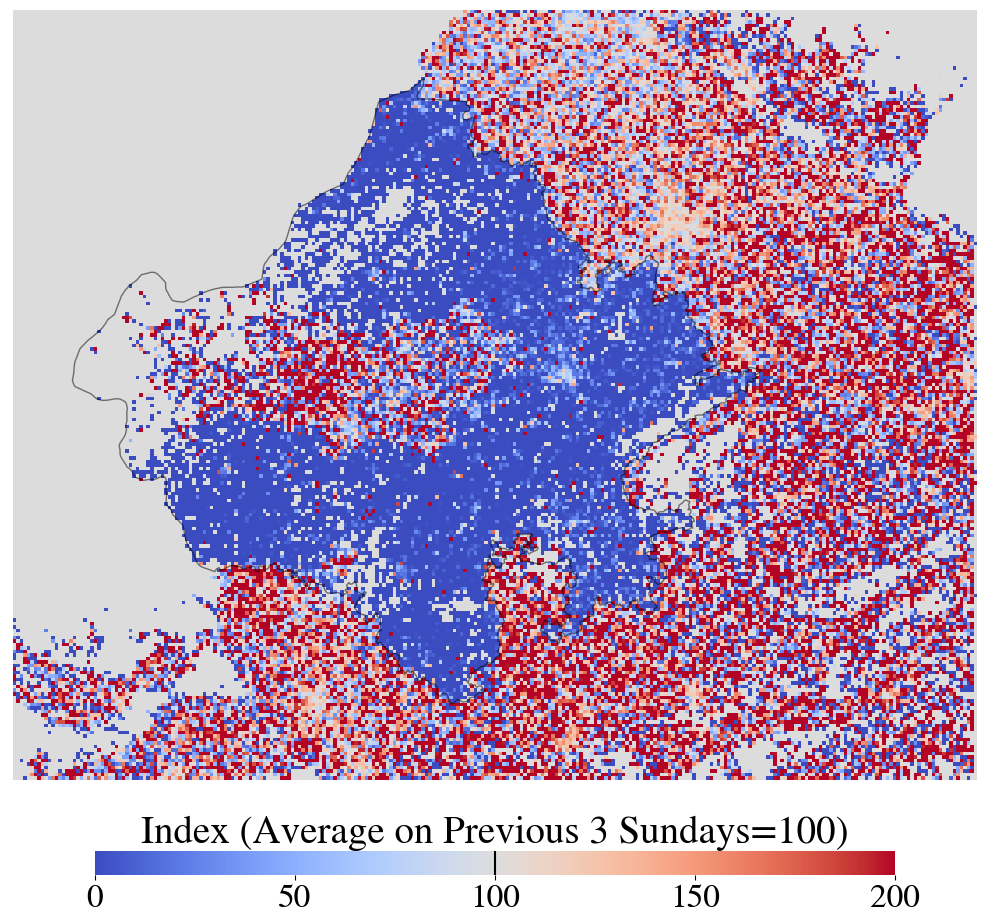

In [11]:
from matplotlib.cm import ScalarMappable

gdf['count_scaled'] = gdf['count_norm'] 
# Load the shapefile data
states_gdf = gpd.read_file(os.path.join(data_in, 'india', 'india_states_shapefile'))

# Convert the CRS of the states GeoDataFrame to match the CRS of the Rajasthan GeoDataFrame
states_gdf = states_gdf.to_crs(gdf.crs)


# Extract the geometry for Rajasthan
rajasthan_geometry = states_gdf[states_gdf['name_1'] == 'Rajasthan']['geometry']

# Reset the limits for the zoom (to show the entire Rajasthan)
rajasthan_extent = states_gdf[states_gdf['name_1'] == 'Rajasthan'].total_bounds
xlim = (rajasthan_extent[0], rajasthan_extent[2])
ylim = (rajasthan_extent[1], rajasthan_extent[3])

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the data
vmax = 200
im = gdf.plot(column="count_scaled", cmap='coolwarm', vmin=0, vmax=vmax, ax=ax)

# Plot the Rajasthan border
rajasthan_geometry.boundary.plot(color='k', linewidth=1, ax=ax, alpha=0.5)



# Create a mappable for colorbar using ScalarMappable
norm = plt.Normalize(vmin=0, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='coolwarm')
sm.set_array([]) # Need to set_data with an empty array


# Position and add the colorbar
cbar_ax = fig.add_axes([0.1, -0.1, 0.8, 0.03])  # [left, bottom, width, height]
cbar_ax.set_title(r"Index (Average on Previous 3 Sundays=100)", fontsize=28, loc = "center")
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.ax.axvline(100, color='k')  # Add vertical line at 100
cbar.ax.tick_params(labelsize=24)
cbar.outline.set_visible(False)


# Remove padding and axis
ax.set_axis_off()
ax.set_rasterized(True)
ax.margins(0)
ax.axis("equal")


# Set the plot limits to match the defined zoom area
plt.tight_layout()


plt.savefig("india_gridy.pdf", bbox_inches="tight")

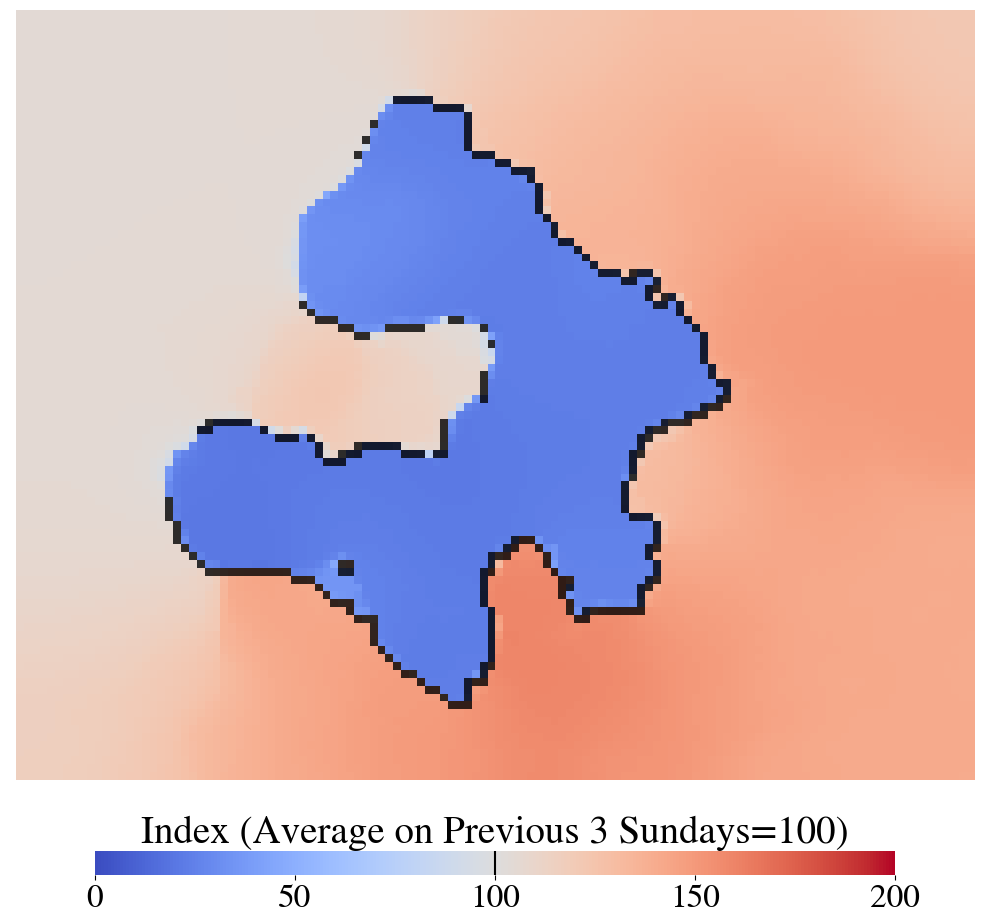

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
im = plt.imshow(u.T, cmap = "coolwarm", origin="lower", vmin=0, vmax=200,
               interpolation="none")
ax.set_axis_off()
ax.axis("equal")
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, -0.1, 0.8, 0.03])  # [left, bottom, width, height]
cbar_ax.set_title(r"Index (Average on Previous 3 Sundays=100)", fontsize=28, loc = "center")
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=24)
cbar.outline.set_visible(False)



# Add a vertical line inside the colorbar at 100
cbar.ax.axvline(100, color='k')

J_temp = J_grid.copy()
J_temp = J_temp.astype(float)
J_temp[J_temp == 0] = np.nan
ax.imshow(J_temp.T, cmap = "binary_r", origin="lower", alpha=0.8)

plt.savefig("india_u.pdf", bbox_inches="tight")


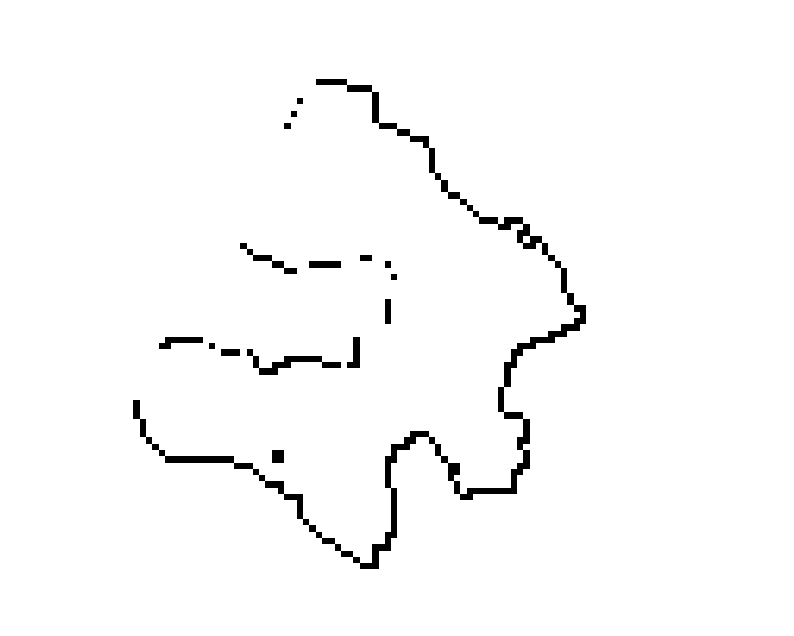

In [13]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

img = ax.imshow(J_grid.T, cmap = "binary", origin="lower")
ax.set_axis_off()
ax.axis("equal")
plt.savefig("india_Jgrid.pdf", bbox_inches="tight")

In [14]:
# plot treatment effect curve
jumps = model.boundaryGridToData(J_grid, u)
jumpdf = pd.DataFrame(jumps)

jumpdf['Y_jumpsize'] = jumpdf['Y_jumpsize'].abs()

Xplot = np.zeros(model.grid_x.shape[:-1])

for index,row in jumpdf.iterrows():
  Xplot[int(row['X_0'] / model.resolution), int(row['X_1'] / model.resolution)] = np.abs(row['Y_jumpsize'])
#Xplot = Xplot * 100

In [15]:
Xplot.shape

(122, 98)

In [16]:
from scipy.ndimage import gaussian_filter

# Apply Gaussian filter
smoothed_parts = gaussian_filter(Xplot[Xplot != 0], sigma=1)
smoothed_Xplot = Xplot.copy()
smoothed_Xplot[Xplot != 0] = smoothed_parts

/tmp/ipykernel_442636/3080277893.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


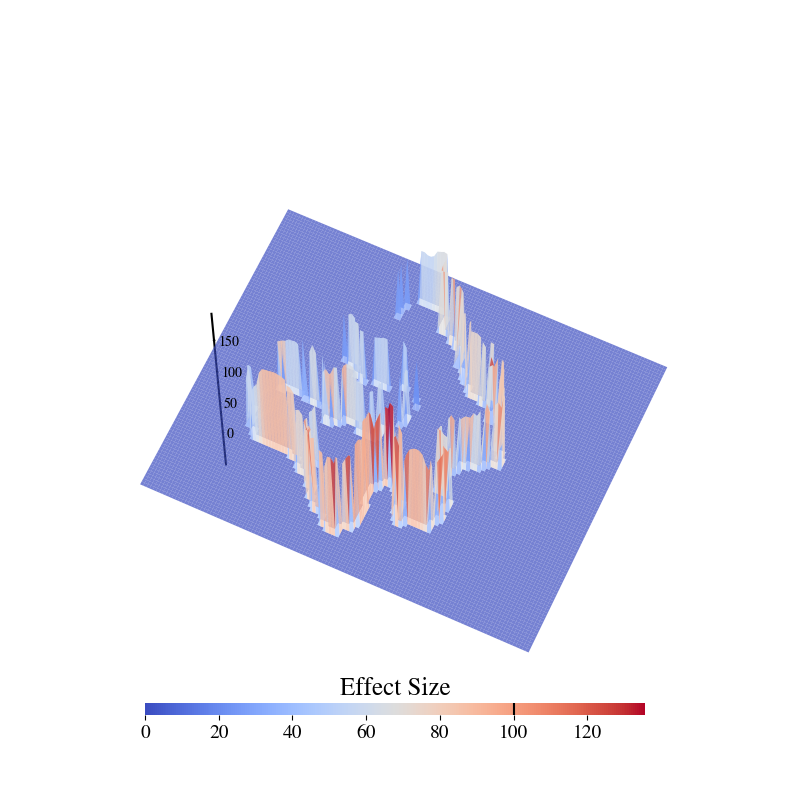

In [17]:
from mpl_toolkits.mplot3d.axes3d import *
from matplotlib import cm

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


cmap = plt.cm.coolwarm
lowest_color = cmap(0.0)
im = ax.plot_surface(model.grid_x[...,1]*300, model.grid_x[...,0]*300, Xplot, 
                rstride=1, cstride=1, antialiased=True, 
                cmap="coolwarm", edgecolor=(0,0,0,0), alpha=0.7)

# Set z-axis limits
zmin = 0
ax.set_zlim(bottom=zmin)

ax.set_axis_off()
ax.axis("equal")
ax.margins(0)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Draw the artificial z-axis. This example places it at the left front corner.
x_start, y_start = 35, 60
z_lim = ax.get_zlim()
ax.plot([x_start, x_start], [y_start, y_start], [z_lim[0], z_lim[1]], color='k')

cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.015])  # [left, bottom, width, height]
cbar_ax.set_title("Effect Size", fontsize=18, loc="center")
temp = Xplot.copy()
temp[temp>200] = 200
m = cm.ScalarMappable(cmap="coolwarm")
m.set_array(temp)
cbar = plt.colorbar(m, cax=cbar_ax, orientation='horizontal')
cbar.outline.set_visible(False)
cbar.ax.axvline(100, color='k')  # Add vertical line at 100
cbar.ax.tick_params(labelsize=14)


# Label the z-axis
# ax.text(x_start, y_start, 1.1*z_lim[1], 'Index', fontsize=12)

# Add ticks to the artificial z-axis
number_of_ticks = 4
tick_length = 0.2
z_ticks = np.linspace(0, 150, number_of_ticks)
for z_tick in z_ticks:
    ax.plot([x_start, x_start + tick_length], [y_start, y_start], [z_tick, z_tick], color='k')
    ax.text(x_start + 15 * tick_length, y_start, z_tick, f"{z_tick:.0f}", verticalalignment='center')


# Set the view angle
ax.view_init(elev=65, azim=-65)
plt.tight_layout()

plt.savefig("india_treatmentcurve.pdf", bbox_inches="tight", dpi=300)

In [18]:
# store estimates for comparison to economic
print("Median " + str(np.quantile(Xplot[Xplot > 0], 0.5)), " mean: ", str(Xplot[Xplot > 0].mean()))

Median 98.55701245091412  mean:  99.70253136402954


### Plot conformal bands

In [ ]:
X_smaller = model.grid_x.reshape(-1, model.grid_x.shape[-1])[:,::-1] * model.X_raw.max() + np.min(model.X_raw, axis = 0)
Y_smaller = model.grid_y.flatten() * model.Y_raw.max() + np.min(model.Y_raw)
model.X_raw, model.Y_raw, model.Y = X_smaller, Y_smaller, Y_smaller
model.N = Y_smaller.shape[0]

u_lower, u_upper, J_lower = model.conformalSplit()


In [23]:
J_uc = model.conformalUncertainty(a_bins = 1000)

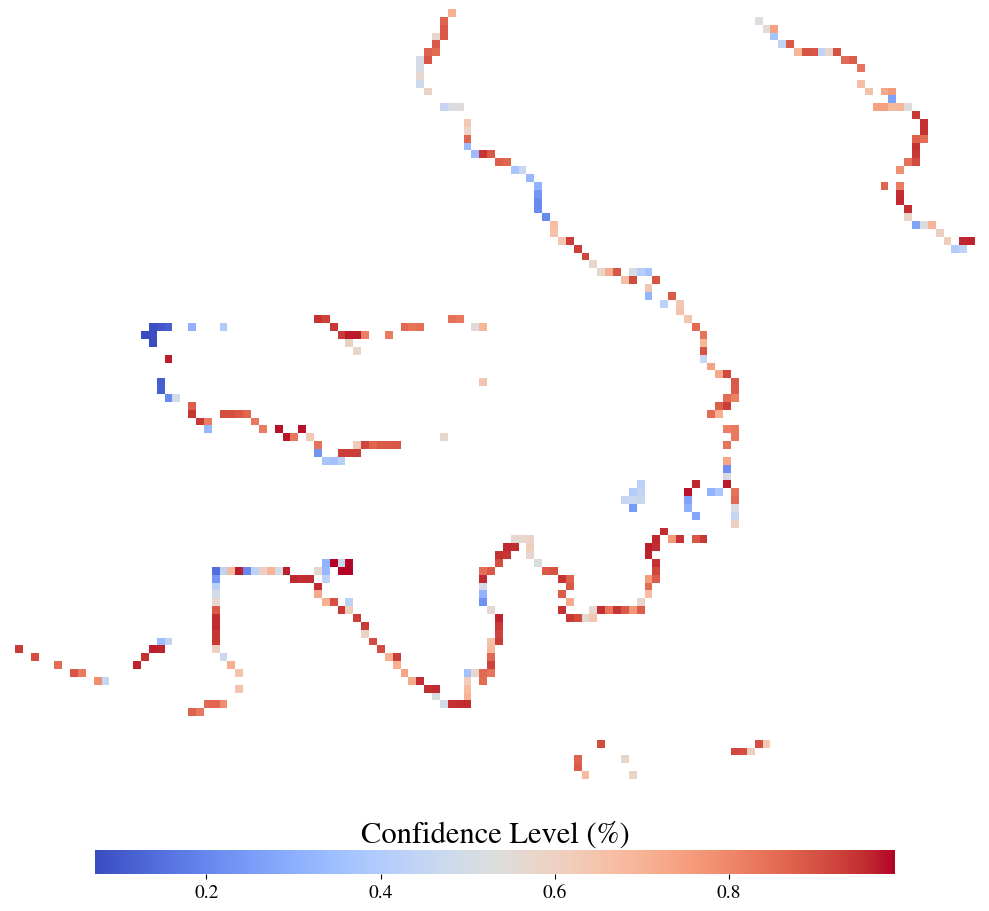

In [24]:
J_mult = J_grid.copy().astype(float)
J_mult[J_mult == 0] = np.nan
J_plot = J_uc * J_mult
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
vmin = (J_uc).min()
im = plt.imshow((J_plot).T  , cmap = "coolwarm", origin="lower", 
               interpolation="none", vmin = J_plot[~np.isnan(J_plot)].min())
ax.set_axis_off()
ax.axis("equal")
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, -0.1, 0.8, 0.03])  # [left, bottom, width, height]
cbar_ax.set_title(r"Confidence Level (%)", fontsize=22, loc = "center")
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
# num_ticks = 12  # Replace this with the number of ticks you want
# cbar.locator = plt.MaxNLocator(num_ticks)
cbar.outline.set_visible(False)
plt.savefig("india_uncertainty_mobile.pdf", bbox_inches="tight", dpi=300)

In [25]:
mask = np.ones(J_plot.shape, dtype=bool)
mask.T[80:100, 90:120] = False

print("10% Sign. " + str((J_plot[mask] > 0.90).sum()  / (J_plot[mask] > 0).sum()) + "5% Sign. " + str((J_plot[mask] > 0.95).sum()  / (J_plot[mask] > 0).sum()))



10% Sign. 0.29117647058823535% Sign. 0.12058823529411765


## Economic

### Rerun model

In [ ]:
fn_merged = os.path.join(data_out, 'india', 'rajasatan_cheating_shops_merged_40K_devices_agg.csv')
gdf = pd.read_csv(fn_merged)
# gdf = gdf.to_crs('epsg:3857')

gdf['shops_ratio'] = gdf['shops_ratio'] * 100
# gdf['shops_ratio'] = np.where(gdf['count_before'] == 0, 100, gdf['count_norm'])
print(gdf.head())
Y = np.array(gdf['shops_ratio'])
X = np.stack([np.array(gdf.y), np.array(gdf.x)]).T

qtile = 150 # np.quantile(Y, 0.85)
Y[Y>qtile] = qtile

In [ ]:
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.x, gdf.y))

In [ ]:
# get SURE parameters
fto = os.path.join(data_out, 'india_econ_SURE_devices_lambda5_nu075-015.pkl') 
with open(fto, "rb") as f:
    res = pickle.load(f)

best = res.get_best_result(metric = "score", mode = "min")

config = best.metrics['config']
lmbda, nu = config['lmbda'], config['nu']
print(lmbda, nu)

In [ ]:
resolution = 1/int(np.sqrt(Y.size))
model = FDD(Y, X, level = 32, lmbda = lmbda, nu = nu, iter = 50000, tol = 1e-5, resolution=resolution,
    pick_nu = "MS", scaled = True, scripted = False, rectangle=True, CI=False)

In [ ]:
import time
start_time = time.time()
results = model.run()
end_time = time.time()
execution_time = end_time - start_time
print("Execution time: {:.2f} seconds".format(execution_time))

In [ ]:
J_grid = results['J']
u = results['u']


### Get uncertainty estimates

In [ ]:
u = np.load(os.path.join(data_out, 'subsampling', 'india_econ_u.npy'))

boots = np.load(os.path.join(data_out, 'subsampling', 'india_econ_boots.npy'))
# boots = boots[0:boots.shape[0]-1,...]
b = np.load(os.path.join(data_out, 'subsampling', 'india_econ_boots_b.npy'))

In [ ]:
# did a loop tailored to the 8-gpu machine on aws so I need to reshape the resulting bootstrap array
#Reshape the array into 800x25x31 by stacking along the first dimension
reshaped_array = boots.reshape(-1, *boots.shape[2:])


# Reorganize the 800x25x31 array into a 200x4x25x31 array
# Take every 1st, 2nd, 3rd, and 4th element along the 800 dimension and expand into the second dimension
boots = reshaped_array.reshape(-1, 4, *reshaped_array.shape[1:])

In [ ]:
boots = boots[0:boots.shape[0]-1,...]

In [ ]:

# Define a function to interpolate
def interpolate(values, position):
    lower_idx = int(np.floor(position)) - 1  # -1 because Python uses 0-based indexing
    upper_idx = int(np.ceil(position)) - 1
    fraction = position - lower_idx - 1
    return values[lower_idx] + (values[upper_idx] - values[lower_idx]) * fraction

def getBootCI(u, boots, b, N):
    # calculate bootstrap distribution
    zlist = []
    for i in range(boots.shape[1]):
        diff = np.max(np.abs(boots[:,i,:] - u),axis=tuple(range(1,boots.ndim-1)))
        #diff = np.linalg.norm(boots[:,i,:] - u, axis=1)
        zlist.append(diff)

    # calculate quantiles 
    qlist = []
    k = ((boots.shape[0]+1) * np.arange(0.05, 0.5, 0.01)).round().astype(int)
    l = ((boots.shape[0]+1) * np.arange(0.51, 0.96, 0.01)).round().astype(int)
    for i in range(boots.shape[1]):
        z_star = zlist[i]
        sz_star = np.partition(z_star, np.hstack([k-1, l-1]))
        qlist.append(sz_star[l-1] - sz_star[k-1])

    # log difference of quantiles
    qlist = np.stack(qlist)
    lqlist = np.log(qlist)
    y = np.mean(lqlist, axis=1)

    # regression
    beta = np.cov(-y, np.log(b))[0,1] / np.var(np.log(b), ddof=1)

    # confidence interval calculation
    m = boots.shape[1]-1
    b_m = b[m]
    u_star_m = boots[:,m,:]
    alpha=0.05
    z_star = b_m**beta * np.max(np.abs(u_star_m - u), axis=1)

    # Number of bootstrap samples
    n_boots = z_star.shape[0]

    # Calculate the positions for the lower and upper percentiles
    position_upper = (n_boots + 1) * alpha # uniform bounds so a single critical value

    # Sort the z_star values along the bootstrap samples axis
    sorted_z_star = np.sort(z_star, axis=0)

    # 
    if not np.isclose(position_upper, np.round(position_upper)):
        crit_val = interpolate(sorted_z_star, position_upper)
    else:
        crit_val = sorted_z_star[int(position_upper)-1]
        


    ci_lower = u - crit_val / N**beta
    ci_upper = u + crit_val / N**beta
 
    return {'ci_lower' : ci_lower, 'ci_upper' : ci_upper, 'beta' : beta}

In [ ]:
N = 68909324 # retrieved this manually
ci_lower, ci_upper, beta = getBootCI(u, boots, b, N).values()

In [ ]:
u_diff = model.forward_differences(u, D=u.ndim).squeeze().transpose(1,2,0)
boots_diff = np.empty(boots.shape + (2,))
for i in range(boots.shape[0]):
    for j in range(boots.shape[1]):
        temp = boots[i,j,...]
        boots_diff[i,j,...] = model.forward_differences(temp, D=temp.ndim).squeeze().transpose(1,2,0)

In [ ]:
u_diff.shape

In [ ]:
# get confidence bands for FD
ci_lower_diff, ci_upper_diff, beta_diff = getBootCI(u_diff, boots_diff, b, N).values()

In [ ]:
J_temp = J_grid.copy()
J_temp = J_temp.astype(float)
J_temp[J_temp == 0] = np.nan
J_lower = J_temp * ((np.max(ci_lower_diff, axis=-1) > 0).astype(int) + (np.min(ci_upper_diff, axis=-1) < 0).astype(int) > 0)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
im = plt.imshow(u, cmap = "coolwarm", origin="lower",
               interpolation="none", vmax=150, vmin=0)
ax.set_axis_off()
ax.axis("equal")
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, -0.1, 0.8, 0.03])  # [left, bottom, width, height]
cbar_ax.set_title(r"Index (Average on Previous 3 Sundays=100)", fontsize=28, loc = "center")
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=24)
cbar.outline.set_visible(False)



# Add a vertical line inside the colorbar at 100
cbar.ax.axvline(100, color='k')

cmap = mpl.colors.ListedColormap(['grey', 'white'])

ax.imshow(J_temp, cmap = cmap, origin="lower", alpha=0.8) # grey if not significant
ax.imshow(J_lower, cmap = "binary_r", origin="lower", alpha=0.8) # black if significant



plt.tight_layout()

plt.savefig("india_econ_u.pdf", bbox_inches="tight", dpi=300)
np.save("u_econ", u) 

### Raw data

In [ ]:
from matplotlib.cm import ScalarMappable

crs = "epsg:3857"

# create geodataframe from data
temp = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.x, gdf.y))
temp['geometry'] = temp.buffer(20000, cap_style = 3)

# Load the shapefile data
states_gdf = gpd.read_file(os.path.join(data_in, 'india', 'india_states_shapefile'))

# Convert the CRS of the states GeoDataFrame to match the CRS of the Rajasthan GeoDataFrame
states_gdf = states_gdf.to_crs(crs)


# Extract the geometry for Rajasthan
rajasthan_geometry = states_gdf[states_gdf['name_1'] == 'Rajasthan']['geometry']

# Reset the limits for the zoom (to show the entire Rajasthan)
rajasthan_extent = states_gdf[states_gdf['name_1'] == 'Rajasthan'].total_bounds
xlim = (rajasthan_extent[0], rajasthan_extent[2])
ylim = (rajasthan_extent[1], rajasthan_extent[3])

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the data
vmax = 150
im = temp.plot(column="shops_ratio", cmap='coolwarm', vmax=vmax, ax=ax)

# Plot the Rajasthan border
rajasthan_geometry.boundary.plot(color='k', linewidth=3, ax=ax, alpha=0.5)



sm = ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=0, vmax=vmax))
sm.set_array([])  # Need to set_data with an empty array

# Position and add the colorbar
cbar_ax = fig.add_axes([0.1, -0.1, 0.8, 0.03])  # [left, bottom, width, height]
cbar_ax.set_title(r"Index (Average on Previous 3 Sundays=100)", fontsize=28, loc="center")
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
# cbar.set_ylim(0, vmax)
cbar.ax.axvline(100, color='k')  # Add vertical line at 100
cbar.ax.tick_params(labelsize=24)
cbar.outline.set_visible(False)


# Remove padding and axis
ax.set_axis_off()
ax.set_rasterized(True)
ax.margins(0)
ax.axis("equal")


# Set the plot limits to match the defined zoom area
plt.tight_layout()


plt.savefig("india_econ_gridy.pdf", bbox_inches="tight")

### Treatment curve

In [ ]:
# plot treatment effect curve
jumps = model.boundaryGridToData(J_grid, u)
jumpdf = pd.DataFrame(jumps)

jumpdf['Y_jumpsize'] = jumpdf['Y_jumpsize'].abs()

Xplot = np.zeros(model.grid_x.shape[:-1])

for index,row in jumpdf.iterrows():
  Xplot[int(row['X_0'] / model.resolution), int(row['X_1'] / model.resolution)] = np.abs(row['Y_jumpsize'])
#Xplot = Xplot * 100

In [ ]:
# remove parts in the northeast
Xplot[(model.grid_x[...,1]*300 > 220) & (model.grid_x[...,0]*300 > 140)] = 0
Xplot[(model.grid_x[...,1]*300 < 50) & (model.grid_x[...,0]*300 < 45)] = 0
Xplot[(model.grid_x[...,1]*300 > 240)] = 0
Xplot[(model.grid_x[...,0]*300 > 220)] = 0

In [ ]:
from mpl_toolkits.mplot3d.axes3d import *
from matplotlib import cm

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


cmap = plt.cm.coolwarm
lowest_color = cmap(0.0)
im = ax.plot_surface(model.grid_x[...,0]*300, model.grid_x[...,1]*300, Xplot, 
                rstride=1, cstride=1, antialiased=True, 
                cmap="coolwarm", edgecolor=(0,0,0,0), alpha=0.7)

# Set z-axis limits
zmin = 0
ax.set_zlim(bottom=zmin)

ax.set_axis_off()
ax.axis("equal")
ax.margins(0)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Draw the artificial z-axis. This example places it at the left front corner.
# You can adjust the X, Y coordinates as needed.
x_start, y_start = 35, 30 # x_start, y_start = 35, 75
z_lim = ax.get_zlim()
ax.plot([x_start, x_start], [y_start, y_start], [0, 100], color='k')

# Label the z-axis
# ax.text(x_start, y_start, 1.1*z_lim[1], 'Index', fontsize=12)

cbar_ax = fig.add_axes([0.25, 0.15, 0.5, 0.015])  # [left, bottom, width, height]
cbar_ax.set_title("Effect Size", fontsize=18, loc="center")
m = cm.ScalarMappable(cmap="coolwarm")
m.set_array(Xplot)
cbar = plt.colorbar(m, cax=cbar_ax, orientation='horizontal')
cbar.outline.set_visible(False)
cbar.ax.axvline(100, color='k')  # Add vertical line at 100
cbar.ax.tick_params(labelsize=14)

# Add ticks to the artificial z-axis
number_of_ticks = 3
tick_length = 0.2
z_ticks = np.linspace(0, 100, number_of_ticks)
for z_tick in z_ticks:
    ax.plot([x_start, x_start + tick_length], [y_start, y_start], [z_tick, z_tick], color='k')
    ax.text(x_start + 15 * tick_length, y_start, z_tick, f"{z_tick:.0f}", verticalalignment='center')


# Set the view angle
ax.view_init(elev=60, azim=-65)
plt.tight_layout()

plt.savefig("india_econ_treatmentcurve.pdf", bbox_inches="tight", dpi=300)




In [41]:
print("Median " + str(np.quantile(Xplot[(Xplot < 100) & (Xplot > 50)], 0.5)), " mean: ", str(Xplot[(Xplot > 50) & (Xplot < 100)].mean()))


Median 38.790348172187805  mean:  35.32964121887662


In [40]:
Xplot[Xplot>0].mean()

50.516304947525306

### Conformal inference

In [35]:
import random
random.seed(9910)
model.alpha = 0.05
u_lower, u_upper, J_lower = model.conformalSplit()
#u_lower, u_upper, J_lower = model.conformalSplitBounds(alpha=0.1)


/home/dvdijcke/fdd/src/FDD/primaldual_multi_scaled_tune.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
/home/dvdijcke/fdd/src/FDD/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res


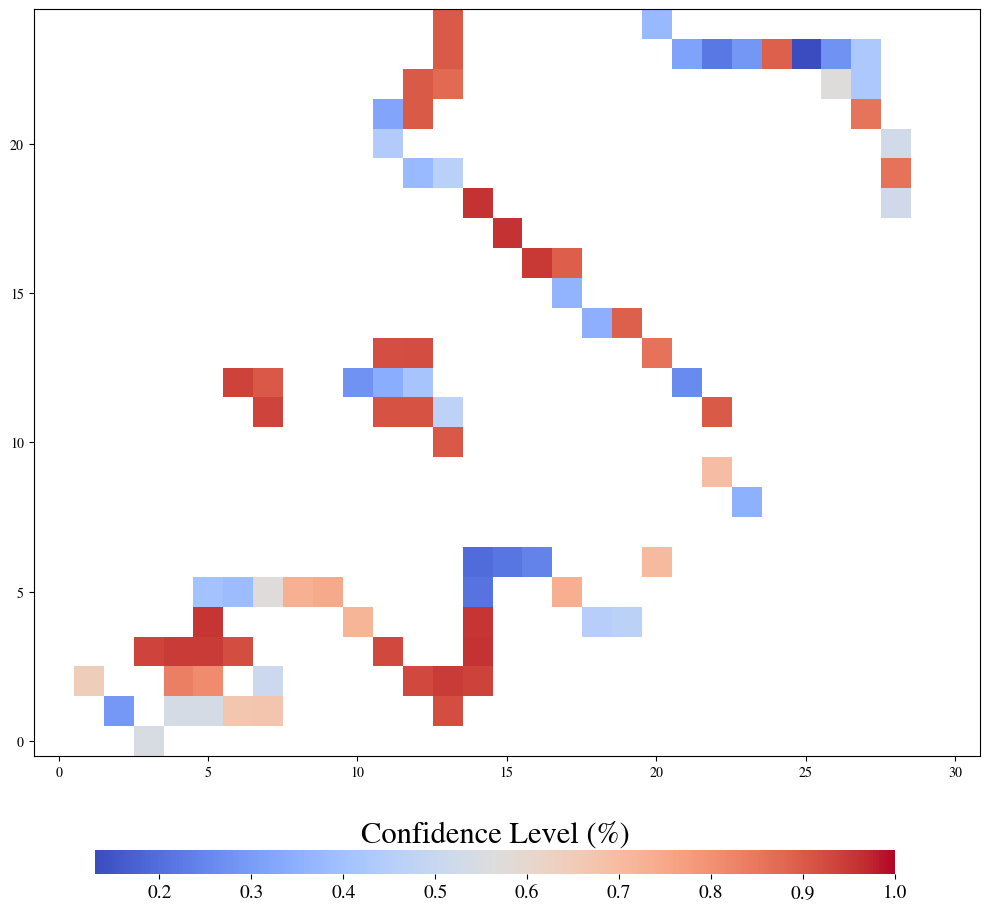

In [36]:
J_uc = model.conformalUncertainty(a_bins = 300)

J_mult = J_grid.copy().astype(float)
J_mult[J_mult == 0] = np.nan
J_plot = J_uc * J_mult
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
vmin = (J_uc).min()
im = plt.imshow((J_plot).T , cmap = "coolwarm", origin="lower", 
               interpolation="none", vmin = J_plot[~np.isnan(J_plot)].min(), vmax=1)
#ax.set_axis_off()
ax.axis("equal")
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, -0.1, 0.8, 0.03])  # [left, bottom, width, height]
cbar_ax.set_title(r"Confidence Level (%)", fontsize=22, loc = "center")
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
num_ticks = 10  # Replace this with the number of ticks you want
cbar.locator = plt.MaxNLocator(num_ticks)
cbar.outline.set_visible(False)
plt.savefig("india_uncertainty_econ.pdf", bbox_inches="tight", dpi=300)

In [37]:
mask = np.ones(J_plot.shape, dtype=bool)
mask.T[20:30, 20:30] = False

print("10% Sign. " + str((J_plot[mask] > 0.90).sum()  / (J_plot[mask] > 0).sum()) + "5% Sign. " + str((J_plot[mask] > 0.95).sum()  / (J_plot[mask] > 0).sum()))


10% Sign. 0.3239436619718315% Sign. 0.07042253521126761


In [75]:
gdf['pings_share_norm'].describe()

count     980.000000
mean       37.016237
std       483.263073
min      -100.000000
25%       -56.677374
50%         0.000000
75%         0.000000
max      9200.000000
Name: pings_share_norm, dtype: float64

## Calculate Connectivity-Economy Linkage

In [43]:
model.grid_x.shape


(31, 25, 2)

In [36]:
u_mobile.shape

(122, 98)

In [40]:
Xplot

array([[ 0.        ,  0.        ,  0.        , 53.2951566 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , 56.81448058,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 45.63944301,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0